# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [1]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm

In [2]:
!python clean_results.py

In [3]:
df = pd.read_csv('results/results_clean.csv')
print(df.dtypes)
df.head()


method          object
test_scores     object
train_scores    object
basis           object
lag_time         int64
n_components     int64
n_clusters       int64
dtype: object


,method,test_scores,train_scores,basis,lag_time,n_components,n_clusters
0,bayesian,"[1.3776911158951748, 1.3740749840217341, 1.264...","[2.9389462312306645, 2.950642052871998, 2.9298...",close_cont,868,7,216
1,bayesian,"[1.0684842211915222, 1.1161358818514298, 1.143...","[2.0313664449993496, 1.902029834442478, 1.9717...",chi_tor,123,8,719
2,bayesian,"[1.419293959877178, 2.459780516990084, 1.42471...","[2.9952122086182973, 2.9991551430503254, 2.996...",alpha_angle,528,9,503
3,bayesian,"[1.266771869867596, 2.1699129867494955, 2.1975...","[2.9829218758783957, 2.994692237174925, 2.9937...",all_tor,909,6,245
4,bayesian,"[1.502631858780357, 2.094233568665083, 1.25880...","[2.998903280162028, 2.993679670790958, 2.99892...",close-h_cont,228,10,990


In [4]:
df.loc[:, 'id'] = np.arange(df.shape[0])+1

Convert score fields to numeric lists, not strings. 

In [5]:
def to_float(x):
    nums = re.findall('[0-9]+\\.[0-9]+', string=x)
    nums = [float(y) for y in nums]
    return nums

df.loc[:, 'test_scores'] = df.loc[:, 'test_scores'].apply(to_float)
df.loc[:, 'train_scores'] = df.loc[:, 'train_scores'].apply(to_float)

Expand out the individual list scores and label the fold numbers

In [6]:
lst_cols = ['test_scores', 'train_scores']
n_folds = df[lst_cols[0]].str.len()[0] # Assumes all the lists are the same length! 

df_long = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
      for col in df.columns.drop(lst_cols)}
    ).\
assign(fold_num = np.concatenate([np.arange(1, x+1) for x in df[lst_cols[0]].str.len()])).\
assign(**{lst_col:np.concatenate(df[lst_col].values) for lst_col in lst_cols })


In [7]:
df_long.query('method=="random"')

,method,basis,lag_time,n_components,n_clusters,id,fold_num,test_scores,train_scores
7835,random,all_tor,861,8,424,1568,1,1.909310,2.947081
7836,random,all_tor,861,8,424,1568,2,1.698505,2.996456
7837,random,all_tor,861,8,424,1568,3,2.276155,2.995918
7838,random,all_tor,861,8,424,1568,4,1.649213,2.786009
7839,random,all_tor,861,8,424,1568,5,1.687259,2.997979
...,...,...,...,...,...,...,...,...,...
20630,random,ppo_tor,230,8,724,4127,1,1.683005,2.995281
20631,random,ppo_tor,230,8,724,4127,2,1.141850,2.999343
20632,random,ppo_tor,230,8,724,4127,3,1.369045,2.994739
20633,random,ppo_tor,230,8,724,4127,4,2.064755,2.751816


Rescale the lag time 

In [8]:
df_long['lag_time'] *= 0.5

Rename the columns

In [9]:
df_long.rename(columns={'test_scores': 'test_score', 'train_scores': 'train_score'}, inplace=True)

In [10]:
df_basis_method = df_long.loc[:, ['id', 'basis', 'method']].drop_duplicates()

In [11]:
df_basis_method.head()

,id,basis,method
0,1,close_cont,bayesian
5,2,chi_tor,bayesian
10,3,alpha_angle,bayesian
15,4,all_tor,bayesian
20,5,close-h_cont,bayesian


In [12]:
df_ave = df_long.groupby('id').mean().reset_index()
df_ave = df_basis_method.merge(df_ave, on='id', how='inner')

## Fit model - ppo torsions only
### n_clusters only

First generate a data matrix

In [13]:
ppo_rand_idx = (df_ave['basis']=='ppo_tor') & (df_ave['method'] == 'random')

form = 'test_score ~ -1 + n_clusters + lag_time + n_components'
y_obs, x_obs = pt.dmatrices(form, df_ave.loc[ppo_rand_idx, :], return_type='dataframe')

Scale each value to be in the interval (0, 1)

In [14]:
from sklearn.preprocessing import MinMaxScaler
unit_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = pd.DataFrame(unit_scaler.fit_transform(x_obs), columns=x_obs.columns)
x_scaled.head()

,n_clusters,lag_time,n_components
0,0.460914,0.028283,0.666667
1,0.718782,0.863636,0.111111
2,0.422335,0.117172,1.000000
3,0.893401,0.569697,0.111111
4,0.539086,0.482828,0.444444


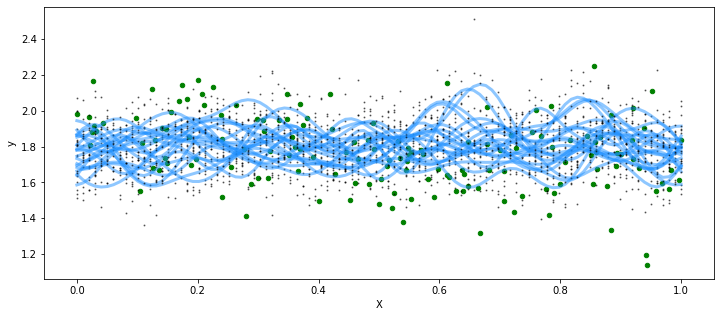

In [21]:
# set the seed
np.random.seed(1)
fig, ax = plt.subplots(figsize=(12,5))
n = 100 # The number of data points
X = np.linspace(0, 1, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 0.05
eta_true = 0.1
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Constant(c=1.8)

for i in range(20):
    # The latent function values are one sample from a multivariate normal
    # Note that we have to call `eval()` because PyMC3 built on top of Theano
    f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                           cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

    # The observed data is the latent function plus a small amount of T distributed noise
    # The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
    sigma_true = 0.1
    y = f_true + np.random.normal(size=n, loc=0, scale=sigma_true)

    ## Plot the data and the unobserved latent function

    ax.plot(X, f_true, "dodgerblue", lw=3, label="True f", alpha=0.5);
    ax.plot(X, y, 'ok', ms=1, label="Data",alpha=0.5);
    ax.set_xlabel("X"); ax.set_ylabel("y");


ax.scatter(x_scaled.loc[:, 'n_clusters'].values, y_obs, color='g', s=20, alpha=1)

Compose a multiplicative kernel. Set the variance to be the overall global variance as a good starting point. 

In [86]:
with pm.Model() as model:
    X, y = x_scaled.loc[:, 'n_clusters'].values[:, np.newaxis], y_obs.values.T[0]
    num_u = 15
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    ℓ = pm.Gamma("ℓ", alpha=0.5, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    σ = pm.HalfCauchy("σ", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=σ)
    mp = pm.find_MAP()



logp = 31.714, ||grad|| = 0.32265: 100%|██████████| 26/26 [00:00<00:00, 244.03it/s]  


In [103]:
X_new = np.linspace(0, 1, 100)[:, np.newaxis]

# with model:
#     y_pred = gp.conditional("y_pred", X_new, pred_noise=True)

with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=100)

100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


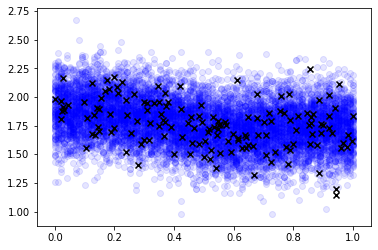

In [108]:
_ = plt.scatter(np.tile(X_new, 100), pred_samples['y_pred'].T, alpha=0.1, color='b')
plt.scatter(X, y, color='k', marker='x')

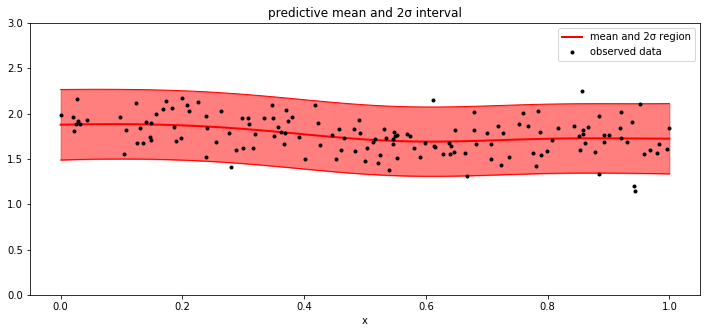

In [114]:
mu, var = gp.predict(X_new, point=mp, diag=True,pred_noise=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");


plt.xlabel("x"); plt.ylim([0,3]);
plt.title("predictive mean and 2σ interval"); plt.legend();


## Two variables

In [116]:
with pm.Model() as model2:
    X, y = x_scaled.loc[:, ['n_clusters', 'lag_time']].values, y_obs.values.T[0]
    num_u = 15
    u_idx = np.random.choice(np.arange(X.shape[0]), num_u)
    Xu = X[u_idx, :]
    
    l_n = pm.Gamma("l_n", alpha=0.5, beta=1)
    l_tau = pm.Gamma("l_tau", alpha=0.5, beta=1)

    eta = pm.HalfCauchy("eta", beta=1)

    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=l_n, active_dims=[0]) * pm.gp.cov.ExpQuad(2, ls=l_tau, active_dims=[1])
    gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=1.8), cov_func=cov, approx="FITC")


    sigma_n = pm.HalfCauchy("sigma_n", beta=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y,Xu=Xu, noise=sigma_n)
    mp = pm.find_MAP()


 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|          | 0/5000 [00:00<?, ?it/s] /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 29.914, ||grad|| = 0.40589: 100%|██████████| 26/26 [00:00<00:00, 243.88it/s]  
